In [1]:
# Why noy use linear regression

# Logistic hypothesis

# Parameter estimation

### IMPORTAÇÕES NECESSÁRIAS

In [2]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
import pandas as pd
import numpy as np

from sklearn.datasets import load_breast_cancer
from ipywidgets import interact

%matplotlib widget

### DESCRIÇÃO DO PROBLEMA

Suponha que temos uma relação de pacientes com câncer de mama e precisamos desenvolver um modelo de Aprendizado de Máquina para prever qual a gravidade do câncer destes pacientes. Entre as respostas possíveis, temos que classificar o câncer como **maligno** ou **benigno**.

Dessa forma, o problema não se encaixa como um problema de regressão, mas sim de classificação. Ou seja, queremos prever uma variável qualitativa, como uma categoria (**maligno** ou **benigno**).

Para que os computadores possam "entender" as variáveis qualitativas, é preciso traduzi-las para a linguagem numérica, ex.: benigno = 0; e maligno = 1. Este processo de tradução é chamado de ***encoding*** ou **codificação**.

Veremos mais à frente que estes valores qualitativos podem ser interpretados como a probabilidade de uma determinada amostra pertencer a classe-alvo.

### CARREGAMENTO E VISUALIZAÇÃO DOS DADOS

In [3]:
data = load_breast_cancer(as_frame=True)

print(f"{'-'*80}\nVariáveis independentes: {data['feature_names']} \n{'-'*80}\nVariáveis dependentes: {data['target_names']}")

--------------------------------------------------------------------------------
Variáveis independentes: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension'] 
--------------------------------------------------------------------------------
Variáveis dependentes: ['malignant' 'benign']


In [4]:
print(f'{"-"*100} \nX:')
display(data['data'].head(5))

print(f'{"-"*100} \ny:')
display(data['target'][-10:])

---------------------------------------------------------------------------------------------------- 
X:


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


---------------------------------------------------------------------------------------------------- 
y:


559    1
560    1
561    1
562    0
563    0
564    0
565    0
566    0
567    0
568    1
Name: target, dtype: int32

Ao analisar a base de dados, observa-se que o valor correspondente à classe **maligno** é 0 e aquele correspondente à classe **benigno** é 1. É comum em um problema de classificação binária (duas classes-alvo) que a classe principal a qual se deseja prever seja representada pelo número 1. Dessa forma, por questões didáticas, decidi trocar os valores entre as classes. Ou seja, agora o valor referente à classe **maligno** (classe principal) será 1 e o da classe **benigno** será 0.

**obs: essa mudança de ordem não altera em nada o processo de desenvolvimento e otimização do modelo de regressão logística.**

In [14]:
# utilizar utils

def standardize(x):
    return (x - x.mean(axis=0)) / x.std(axis=0)

In [17]:
X, y = data['data'].values, data['target'].values

y = np.where(y == 0, 1, 0)

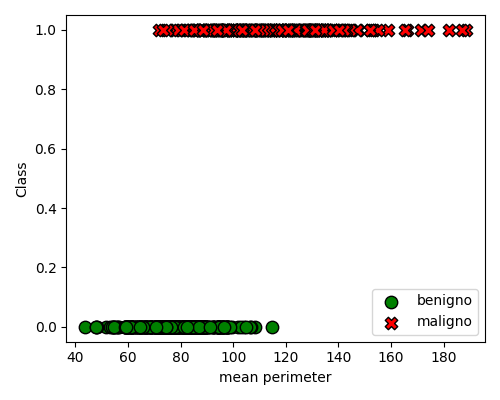

In [18]:
fig = plt.figure(figsize=(5,4))

ax0 = fig.add_subplot(1,1,1)

ax0.scatter(X[:,2][y==0], y[y==0], c='green', ec='black', s=80, marker='o', label='benigno')
ax0.scatter(X[:,2][y==1], y[y==1], c='red', ec='black', s=80, marker='X', label='maligno')
ax0.set_xlabel(data['feature_names'][2])
ax0.set_ylabel('Class')
ax0.legend()

fig.tight_layout()
plt.show()

### POR QUE NÃO USAR REGRESSÃO LINEAR?

Uma vez transformadas as classes em valores binários 0/1, podemos treinar um regressor linear para estimar qual a categoria do câncer de um determinado paciente da seguinte forma:

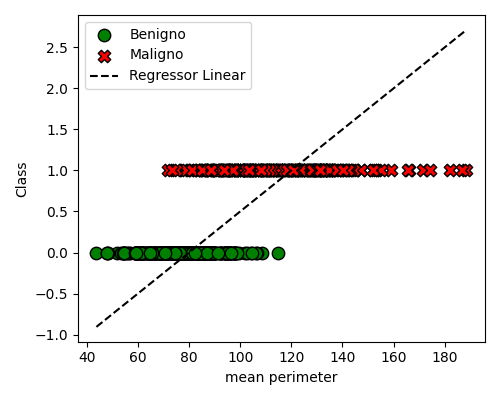

In [7]:
x_ = np.linspace(X[:,2].min(), X[:,2].max(), 10)
y_ = x_ * (1 / 40) - 2 # Linear Regressor

fig = plt.figure(figsize=(5,4))

ax0 = fig.add_subplot(1,1,1)

ax0.scatter(X[:,2][y==0], y[y==0], c='green', ec='black', s=80, marker='o', label='Benigno')
ax0.scatter(X[:,2][y==1], y[y==1], c='red', ec='black', s=80, marker='X', label='Maligno')
ax0.plot(x_, y_, linestyle='--', c='black', label='Regressor Linear')
ax0.set_xlabel(data['feature_names'][2])
ax0.set_ylabel('Class')
ax0.legend()

fig.tight_layout()
plt.show()

Analisando a figura anterior, podemos interpretar os valores preditos pelo regressor linear como uma estimativa de $P(y=1|X)$. Isto é, a probabilidade de uma determinada amostra $X$ pertencer a classe 1 (maligno). Observa-se que os valores estimados pelo regressor linear ultrapassam os limites de probabilidae (0 e 1) e podem variar de $-\infty$ a $+\infty$.

Portanto, é por essas e outras razões que é preferível a utilização de um regressor mais adequado capaz de lidar com valores qualitativos, como o modelo de **Regressão Logística**

### REGRESSÃO LOGÍSTICA

O modelo de Regressão Logística tem esse nome devido à função que serve de hipótese para o modelo: função logística, mais especificamente a função sigmóide.

A imagem da função sigmóide varia entre os valores 0 e 1. Sua equação é descrita da seguinte forma:

$$g(z) = \frac{1}{1 + e^{-z}}$$

Veremos mais à frente que, quando utilizada para modelar um problema de classificação do tipo $P(y=1|X)$, a função precisa ser ajustada e $z$ passa a ser uma abreviação de $w \cdot X + b$ e a versão completa da função é, então:

$$ g_{W, b}(X) = \frac{1}{1 + e^{-(W \cdot X + b)}} $$

onde $g_{W, b}(X) = P(y=1|X)$ é a variável dependente (saída), $X$ são as variáveis independentes (entrada), $W$ e $b$ são parâmetros a serem otimizados.

**OBS: para facilitar, a partir de agora, vamos abreviar $g_{W, b}(X)$ por $\hat{y}$, onde entende-se que $g(.)$ é a resposta calculada pelo modelo ($g(.)=\hat{y}$)**

A forma em "S" da função sigmoide pode ser visualizada na figura a seguir:

In [8]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

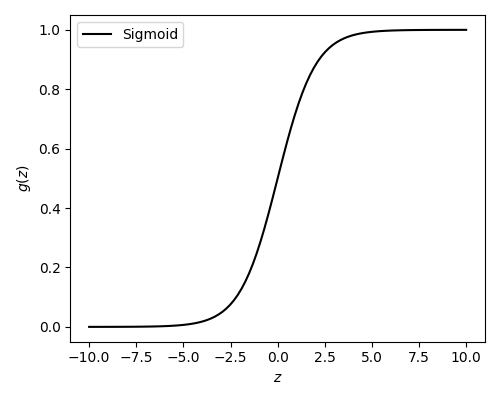

In [9]:
z = np.linspace(-10, 10, 100)
g = sigmoid(z)

fig = plt.figure(figsize=(5,4))

ax0 = fig.add_subplot(1,1,1)

ax0.plot(z, g, c='black', label='Sigmoid')
ax0.set_xlabel('$z$')
ax0.set_ylabel('$g(z)$')
ax0.legend()

fig.tight_layout()
plt.show()

Agora vamos tentar implementar a função logística para receber como entrada as variáveis do nosso problema de classificação de câncer de mama e ver como os parâmetros influenciam a função.

In [19]:
X = standardize(X)

interactive(children=(FloatSlider(value=0.0, description='w', max=10.0, min=-10.0), FloatSlider(value=0.0, des…

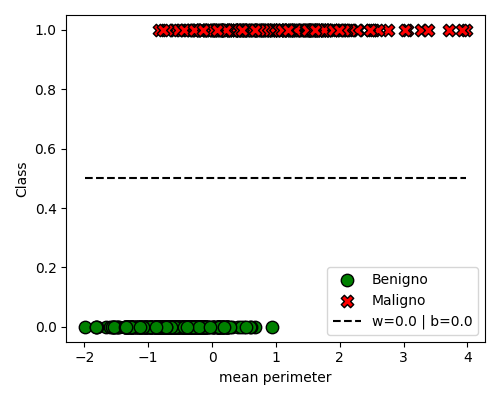

In [24]:
x_ = np.linspace(X[:,2].min(), X[:,2].max(), 1000)

fig = plt.figure(figsize=(5,4))
ax0 = fig.add_subplot(1,1,1)

def update(w, b):

    z = w * x_ + b
    g = sigmoid(z)

    ax0.clear()
    ax0.scatter(X[:,2][y==0], y[y==0], c='green', ec='black', s=80, marker='o', label='Benigno')
    ax0.scatter(X[:,2][y==1], y[y==1], c='red', ec='black', s=80, marker='X', label='Maligno')
    ax0.plot(x_, g, linestyle='--', c='black', label=f'w={round(w, 2)} | b={round(b, 2)}')
    ax0.set_xlabel(data['feature_names'][2])
    ax0.set_ylabel('Class')
    ax0.legend()

interact(update, w=widgets.FloatSlider(value=0, min=-10, max=10), b=widgets.FloatSlider(value=0, min=-10, max=10))

fig.tight_layout()
plt.show()

### OTIMIZAÇÃO DOS PARÂMETROS

Quando desejamos modelar um regressor logístico para um problema de classificação, estimamos uma função logística cujos coeficientes $W$ e $b$ são desconhecidos. Portanto, é necessário estimar os coeficientes de maneira que a curva melhor se ajuste aos dados de treinamento.

Para a otimização dos coeficientes do modelo de Regressão Linear, é utilizado o método dos Mínimos Quadrados para minimizar a diferença entre os dados preditos $\hat{y}$ e reais $y$ da seguinte forma:

$$ MSE = \frac{1}{2m} \sum_{i=0}^{m-1} (\hat{y_{i}} - y_{i})^{2} $$

A utilização da MSE como função custo da Regressão Logística não é indicada e abaixo demonstraremos o porquê:

In [26]:
def mse(y_pred, y):
    return np.mean((y_pred - y)**2, axis=0) / 2

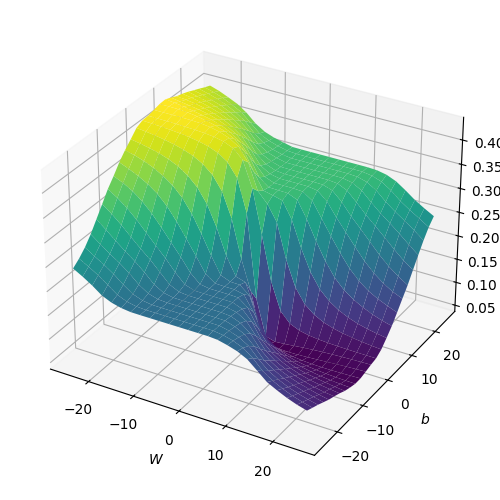

In [27]:
n_grid = 25

w_ = np.linspace(-25, 25, n_grid).reshape(1,-1)
b_ = np.linspace(-25, 25, n_grid).reshape(1,-1)
W_, B_ = np.meshgrid(w_, b_)

x_ = X[:, 2].reshape(-1,1)
z_ = np.dot(x_, W_.reshape(1,-1)) + B_.reshape(1,-1)
y_pred = sigmoid(z_)

mse_ = mse(y_pred, np.tile(y.reshape(-1,1), n_grid**2))
mse_ = mse_.reshape(n_grid, n_grid)

fig = plt.figure(figsize=(5,5))

ax0 = fig.add_subplot(111, projection='3d')
ax0.plot_surface(W_, B_, mse_, cmap='viridis')
ax0.set_xlabel('$W$')
ax0.set_ylabel('$b$')
ax0.set_zlabel('$MSE$')

fig.tight_layout()
plt.show()

Devido ao fato de a função logística (sigmoide) ser não-linear, a função MSE, quando utilizada no contexto da Regressão Logística, assume uma forma não-convexa. Isto é, existem vários pontos da função custo diferentes do mínimo global que também possuem derivadas parciais com relação aos parâmetros iguais a 0. Dessa forma, a otimização dos parâmetros através do metódo Gradiente Descendente é prejudicada, uma vez que quando o gradiente é nulo não há atualização.

Ao invés de utilizar a MSE, é utilizada uma abordagem diferente: da Probabilidade Máxima (*Maximum Likelihood*). A estimativa dos coeficientes de um modelo de Regressão Logística é dada de tal forma a maximizar as probabilidades de classificação em cada classe.

$ \begin{equation}
    \begin{align*}
        \text{Likelihood} = L(y, \hat{y}) & = \prod_{i=0}^{m-1} P(y_{i}=1|X_{i})^{y_{i}} \prod_{i=0}^{m-1} P(y_{i}=0|X_{i})^{1-y_{i}} \\
        & = \prod_{i=0}^{m-1} P(y_{i}=1|X_{i})^{y_{i}} \prod_{i=0}^{m-1} \left[ 1 - P(y_{i}=1|X_{i}) \right]^{1-y_{i}} \\
        & = \prod_{i=0}^{m-1} \hat{y_{i}}^{y_{i}} \prod_{i=0}^{m-1} \left( 1 - \hat{y_{i}} \right)^{1-y_{i}}
    \end{align*}
\end{equation} $

Através do produtório das probabilidades preditas para cada classe, a função *Likelihood* mede o nível de acerto do modelo em uma escala de probabilidade $[0, 1]$.

In [66]:
def likelihood(y, y_hat):
    return np.prod(y_hat**y * (1 - y_hat)**(1-y), axis=0)

interactive(children=(FloatSlider(value=1.0, description='w', max=10.0, min=-10.0), FloatSlider(value=0.0, des…

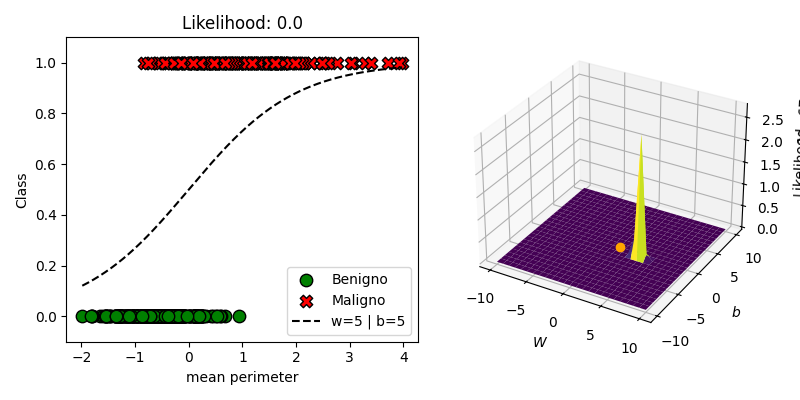

In [89]:
x = X[:,2].reshape(-1,1)
x_ = np.linspace(x.min(), x.max(), 1000)

N = 25

w_max = b_max = 10
w_min = b_min = -w_max

w_ = np.linspace(w_min, w_max, N).reshape(1,-1)
b_ = np.linspace(b_min, b_max, N).reshape(1,-1)
W_, B_ = np.meshgrid(w_, b_)

Z_ = np.dot(x, W_.reshape(1,-1)) + B_.reshape(1,-1)
Y_hat_ = sigmoid(Z_)

L_ = likelihood(np.tile(y.reshape(-1,1), N**2), Y_hat_)
L_ = L_.reshape(N, N)

fig = plt.figure(figsize=(8,4))

ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122, projection='3d')

ax0.scatter(x[y==0], y[y==0], c='green', ec='black', s=80, marker='o', label='Benigno')
ax0.scatter(x[y==1], y[y==1], c='red', ec='black', s=80, marker='X', label='Maligno')
ax0_line, = ax0.plot(x_, x_, linestyle='--', c='black', label=f'w={round(w, 2)} | b={round(b, 2)}')
ax0.set_xlabel(data['feature_names'][2])
ax0.set_ylabel('Class')
ax0.set_ylim(-.1, 1.1)
ax0.legend()

ax1.plot_surface(W_, B_, L_, cmap='viridis', zorder=0)
ax1_line, = ax1.plot([], [], [], marker='o', color='orange', zorder=3)
ax1.set_xlabel('$W$')
ax1.set_ylabel('$b$')
ax1.set_zlabel('Likelihood')

def update(w, b):

    z_ = w * x_ + b
    z = w * x + b
    y_hat_ = sigmoid(z_)
    y_hat = sigmoid(z)
    lh = np.prod(y_hat**y * (1 -y_hat)**(1-y))
    
    ax0_line.set_ydata(y_hat_)
    ax0_line.set_label(f'w:{w} | b:{b}')
    ax0.set_title(f'Likelihood: {lh}')

    ax1_line.set_data([w], [b])
    ax1_line.set_3d_properties(lh)

interact(update, w=widgets.FloatSlider(value=1, min=w_min, max=w_max), b=widgets.FloatSlider(value=0, min=b_min, max=b_max))

fig.tight_layout()
plt.show()

Observando os resultados da função *Likelihood*, tem-se que, devido ao produtório de uma série de valores menores que 1 e maiores que 0, o valor da probabilidade total é muito baixo. Para contornar esse problema, a função logarítmica é aplicada à função *Likelihood*: 

$$ \begin{equation*}
    log \left(L(y, \hat{y}) \right) = log\left(\prod_{i=0}^{m-1} \hat{y_{i}}^{y_{i}} \prod_{i=0}^{m-1} \left( 1 - \hat{y_{i}} \right)^{1-y_{i}}\right)
\end{equation*} $$

Aplicando a seguinte propriedade do logarítmo: $log(A \cdot B)=log(A)+log(B)$ e chamando $log(L(y, \hat{y}))$ de $LL(y, \hat{y})$ temos que

$$ \begin{equation*}
    \begin{align*}
        LL(y, \hat{y}) & = \sum_{i=0}^{m-1} log(\hat{y_{i}}^{y_{i}}) + log([1 - \hat{y_{i}}]^{1 - y_{i}}) \\
        & = \sum_{i=0}^{m-1} y_{i} \cdot log(\hat{y_{i}}) + (1 - y_{i}) log([1 - \hat{y_{i}}]) \\
    \end{align*}
\end{equation*} $$

Com isso, temos a expressão para o *log-likelihood*. Sua forma pode ser visualizada na figura abaixo:

In [92]:
def log_likelihood(y, y_hat):
    return np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat), axis=0)

In [97]:
y.shape, y_hat.shape, log_likelihood(y,y_hat)

((569,), (569,), -920.1976505197056)

C:\Users\JPG\AppData\Local\Temp\ipykernel_2848\2249946228.py:2: RuntimeWarning: divide by zero encountered in log
  return np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat), axis=0)
C:\Users\JPG\AppData\Local\Temp\ipykernel_2848\2249946228.py:2: RuntimeWarning: invalid value encountered in multiply
  return np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat), axis=0)


interactive(children=(FloatSlider(value=1.0, description='w', max=10.0, min=-10.0), FloatSlider(value=0.0, des…

C:\Users\JPG\AppData\Local\Temp\ipykernel_2848\1467264623.py:56: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  fig.tight_layout()


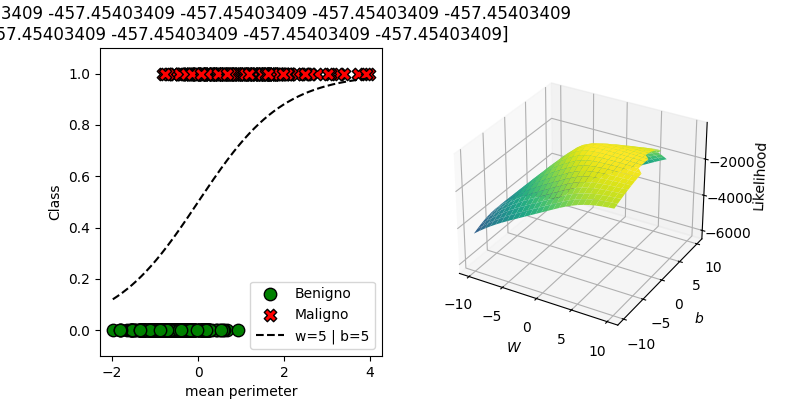

In [94]:
x = X[:,2].reshape(-1,1)
x_ = np.linspace(x.min(), x.max(), 1000)

N = 25

w_max = b_max = 10
w_min = b_min = -w_max

w_ = np.linspace(w_min, w_max, N).reshape(1,-1)
b_ = np.linspace(b_min, b_max, N).reshape(1,-1)
W_, B_ = np.meshgrid(w_, b_)

Z_ = np.dot(x, W_.reshape(1,-1)) + B_.reshape(1,-1)
Y_hat_ = sigmoid(Z_)

L_ = log_likelihood(np.tile(y.reshape(-1,1), N**2), Y_hat_)
L_ = L_.reshape(N, N)

fig = plt.figure(figsize=(8,4))

ax0 = fig.add_subplot(121)
ax1 = fig.add_subplot(122, projection='3d')

ax0.scatter(x[y==0], y[y==0], c='green', ec='black', s=80, marker='o', label='Benigno')
ax0.scatter(x[y==1], y[y==1], c='red', ec='black', s=80, marker='X', label='Maligno')
ax0_line, = ax0.plot(x_, x_, linestyle='--', c='black', label=f'w={round(w, 2)} | b={round(b, 2)}')
ax0.set_xlabel(data['feature_names'][2])
ax0.set_ylabel('Class')
ax0.set_ylim(-.1, 1.1)
ax0.legend()

ax1.plot_surface(W_, B_, L_, cmap='viridis', zorder=0)
ax1_line, = ax1.plot([], [], [], marker='o', color='orange', zorder=3)
ax1.set_xlabel('$W$')
ax1.set_ylabel('$b$')
ax1.set_zlabel('Likelihood')

def update(w, b):

    z_ = w * x_ + b
    z = w * x + b
    y_hat_ = sigmoid(z_)
    y_hat = sigmoid(z)
    lh = log_likelihood(y, y_hat)
    print(lh)
    
    ax0_line.set_ydata(y_hat_)
    ax0_line.set_label(f'w:{w} | b:{b}')
    ax0.set_title(f'Likelihood: {lh}')

    ax1_line.set_data([w], [b])
    ax1_line.set_3d_properties(lh)

interact(update, w=widgets.FloatSlider(value=1, min=w_min, max=w_max), b=widgets.FloatSlider(value=0, min=b_min, max=b_max))

fig.tight_layout()
plt.show()